# EMA of Curacao EV Vensim Model - FINAL EXPERIMENTS

**Purpose:** Run exploratory experiments on the Curaçao EV model and perform PRIM scenario discovery.

**This notebook:**
- Loads the Vensim model from `./model_files/`
- Runs experiments via `ema_workbench`
- Saves results to `./results/`
- Produces figures into `./figures/`

**Run order:** top → bottom, section by section. Keep the working directory at repo root.

**Sections of this NB**:
1. Set up initial experiment (of n=1500 using all 39 uncertainties)
2. Initial Exploration (of n=1500 dataset)
3. Random Forest (to reduce amount of uncertainties from 39 to at least fewer than 10)
4. Re-run experiment for 12 policy combinations and <10> uncertainties
5. Perform PRIM Scenario discovery on new, smaller dataset for upper and lower bound of scenarios

In [ ]:
# --- Environment & library setup (clean) 
# ~6 seconds to run

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    RealParameter,
    IntegerParameter,
    CategoricalParameter,
    Constant,
    TimeSeriesOutcome,
    perform_experiments,
    save_results,
    load_results,
    ema_logging,
)
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.analysis import prim, feature_scoring, pairs_plotting, plotting

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

def print_versions() -> None:
    """Print key environment versions and paths (direct, compact)."""
    import ema_workbench  # local import to avoid polluting top-level namespace

    print(f"EMA version : {ema_workbench.__version__}")
    print(f"EMA path    : {ema_workbench.__file__}")
    print(f"NumPy       : {np.__version__}")
    print(f"Python exe  : {sys.executable}")

# Fix for older numpy versions that do not have np.NAN 
import numpy as np 
if not hasattr(np, "NAN"): np.NAN = np.nan

if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)
    print_versions()


c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\connectors\__init__.py:29: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


EMA version : 2.5.3
EMA path    : c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\__init__.py
NumPy       : 2.3.3
Python exe  : c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\python.exe


## 1. Set up Initial Experiment

In [2]:
# EXPERIMENTAL SETUP OPEN EXPLORATION
# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO) 

# instantiate a model
wd = "./model_files/" # adjust this path to load different version of model
vensim_model = VensimModel("evmodel", wd=wd, model_file="ev_curacao_model.vpmx") # "21-10 ochtend.vpmx" "20-10 eind middag.vpmx"

uncertainties = [
    # ----------------------------
    # Categorical switches
    # ----------------------------
    CategoricalParameter("Energy price switch", (1, 2, 3)),                         # 1=Stanford, 2=Twente, 3=IET
    CategoricalParameter("Fuel price switch", (1, 2, 3)),                           # 1=high, 2=medium, 3=low
    CategoricalParameter("market price scenario switch", (0, 1, 2)),                # 0=, 1=, 2=

    # --- Initial conditions Cars/EVs
    IntegerParameter("initial total cars", int(78717*0.95), int(78717*1.05)),       # 78717 ±20%
    RealParameter("initial share of EV", 0.0254075*0.9, 0.0254075*1.1),             # 

    # --- CO2 initial levels (FossilVehicle only; EV kept constant at 0)
    RealParameter("initial CO2 0 to 5 yrs[FossilVehicle]", 92, 138),                # 115 ±20%
    RealParameter("initial CO2 5 to 10 yrs[FossilVehicle]", 120, 180),              # 150 ±20%
    RealParameter("initial CO2 10 to 15 yrs[FossilVehicle]", 136, 204),             # 170 ±20%
    RealParameter("initial CO2 15 to 20 yrs[FossilVehicle]", 144, 216),             # 180 ±20%
    RealParameter("initial CO2 20 yrs plus[FossilVehicle]", 152, 228),              # 190 ±20%

    # --- Prices & costs
    RealParameter("operational", 0.3129*0.5, 0.3129*1.5),                           # 0.3129 ±50%
    RealParameter("yearly fee", 343*0.5, 343*1.5),                                  # 343 ±50%
  
    # --- Efficiency / kms driven / growth
    RealParameter("fuel efficiency", 0.11235*0.8, 0.11235*1.2),                             # (1/8.9) ±20% 
    RealParameter("Average kms driven anually[FossilVehicle]", 10000*0.7, 10000*1.3),       # 10000 ±20%
    RealParameter("Average kms driven anually[ElectricVehicle]", 10000*0.7, 10000*1.3),     # 10000 ±20%
    RealParameter('"Car park growth %"', 0.0212*0.5, 0.0212*1.1),                           # 0.0212 -50%, +10%

    # --- Charging infrastructure (constants-only items)
    RealParameter("initial value facilities[FossilVehicle]", 35*0.9, 35*1.1),       # 35 ±20%
    RealParameter("initial value facilities[ElectricVehicle]", 32*0.8, 32*1.2),     # 32 ±20%
    RealParameter("facility ratio[FossilVehicle]", 0.002*0.9, 0.002*1.1),           # 
    RealParameter("facility ratio[ElectricVehicle]", 0.2*0.5, 0.2*1.1),             # 
    RealParameter("Facility delay[FossilVehicle]", 1.5*0.7, 1.5*1.3),               # 0.9 ±20%
    RealParameter("Facility delay[ElectricVehicle]", 0.5*0.7, 1.5*0.7),             # 0.7 ±20%

    # --- Discrete choice (ASC & betas)
    RealParameter("ASC[FossilVehicle]", 0.9*0.8, 0.9*1.2),                          # 0.9 ±20%
    RealParameter("ASC[ElectricVehicle]", 0.1*0.8, 0.1*1.2),                        # 0.1 ±20%
    RealParameter("beta range", 0.00166, 0.00328),                                  # 95% confidence interval from SDC
    RealParameter("beta charging distance", -0.5, -0.06),                           #  95% confidence interval from SDC
    RealParameter("beta charge time", -0.0021, -0.00041),                           # 95% confidence interval from SDC
    RealParameter('"beta fuel/charging costs"', -0.00351, -0.00191),                # (-0.271/100) ±20% 
    RealParameter("beta car price", -5.06e-05*1.5, -5.06e-05*0.5),                  # (-7.59e-05, -2.53e-05)
    
    # --- Out-of-use rates (both vehicle types)
    RealParameter('"out of use % 0 to 5 yr"[FossilVehicle]', 0.0152, 0.0228),       # 0.019 ±20%
    RealParameter('"out of use % 5 to10 yr"[FossilVehicle]', 0.0184, 0.0276),       # 0.023 ±20%
    RealParameter('"out of use % 10 to15 yr"[FossilVehicle]', 0.0408, 0.0612),      # 0.051 ±20%
    RealParameter('"out of use % 15 to 20 yr"[FossilVehicle]', 0.1296, 0.1944),     # 0.162 ±20%
    RealParameter('"out of use % 20 yr plus"[FossilVehicle]', 0.112, 0.168),        # 0.14 ±20%

    RealParameter('"out of use % 0 to 5 yr"[ElectricVehicle]', 0.0152, 0.0228),     #
    RealParameter('"out of use % 5 to10 yr"[ElectricVehicle]', 0.0184, 0.0276),     #
    RealParameter('"out of use % 10 to15 yr"[ElectricVehicle]', 0.0408, 0.0612),    #
    RealParameter('"out of use % 15 to 20 yr"[ElectricVehicle]', 0.1296, 0.1944),   #
    RealParameter('"out of use % 20 yr plus"[ElectricVehicle]', 0.112, 0.168),      #
]

# Define policies as constants for initial run
constants = [
    # Constants can be defined here if needed
    Constant("Emission tax SWITCH", 0),
    Constant("SWITCH Policy EV Tax Cut", 0),
    Constant("Dynaf lever SWITCH", 0),  
]

# Register on the model
vensim_model.uncertainties = uncertainties 
vensim_model.constants = constants

vensim_model.outcomes = [
    TimeSeriesOutcome("Number of EVs"),
    TimeSeriesOutcome("Total CO2 emissions cars[FossilVehicle]"),
    TimeSeriesOutcome("Number of FossilVehicles"),
    ]
 
# RUN THE EXPERIMENTS
results = perform_experiments(vensim_model, 
                              scenarios=1500#,
                              #policies=7
                              )

# split results into experiments and outcomes
experiments, outcomes = results

[MainProcess/INFO] performing 1500 scenarios * 1 policies * 1 model(s) = 1500 experiments
100%|██████████████████████████████████████| 1500/1500 [00:57<00:00, 25.98it/s]
[MainProcess/INFO] experiments finished


#### Save/load results [comment out if not necessary]

In [3]:
# Save results  
save_results(results, "./results/results_no_POLICY.tar.gz")

c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_no_POLICY.tar.gz


In [55]:
# Load results
experiments, outcomes = load_results("./results/results_no_POLICY.tar.gz")

[MainProcess/INFO] results loaded successfully from c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_no_POLICY.tar.gz


## 2. Initial Exploration

### Pairplot

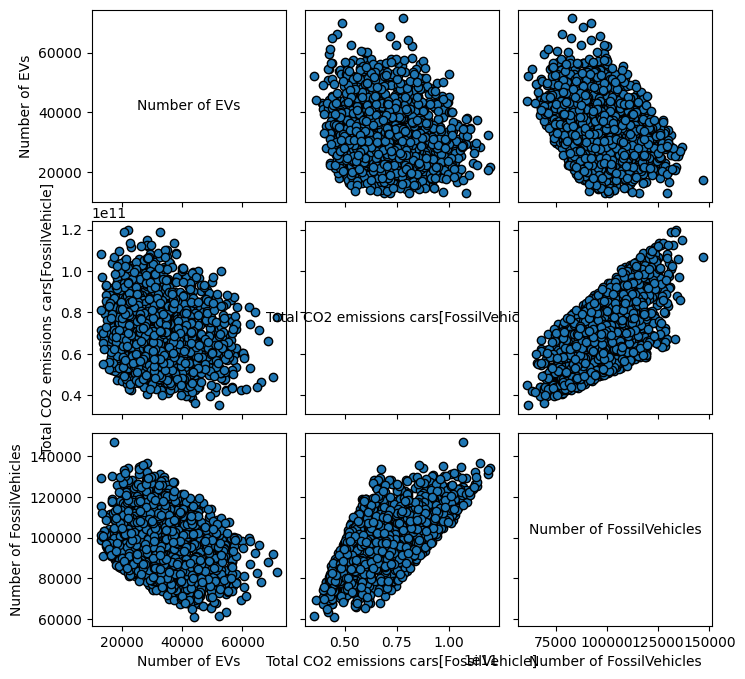

In [56]:
fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, legend=False
)
fig.set_size_inches(8, 8)
plt.show()

**Observations from scatterplots (n = 1,500 runs, all uncertainties varied)**

These scatterplots show how model outcomes co-vary when all uncertainties are varied and no policy scenarios are applied.
<br>
* (Weak) Negative relation between EVs and fossil vehicles: As the number of EVs increases, the number of fossil vehicles decreases — confirming that the total car stock remains relatively stable while the composition shifts.
* Strong positive relation between fossil vehicles and CO₂ emissions: CO₂ emissions scale almost linearly with the number of fossil vehicles, which validates the internal consistency of the emission formulation.
* Inverse relation between EVs and CO₂ emissions: More EV adoption leads to lower total CO₂ emissions, as expected. The spread reflects uncertainty in other factors like fuel efficiency, charging costs, and car park growth.
* Overall scatter width: The broad dispersion in all plots indicates that the model behaves non-linearly under uncertainty — a desirable feature for exploratory modelling, showing sensitivity to multiple interacting inputs.

### Runs Overview

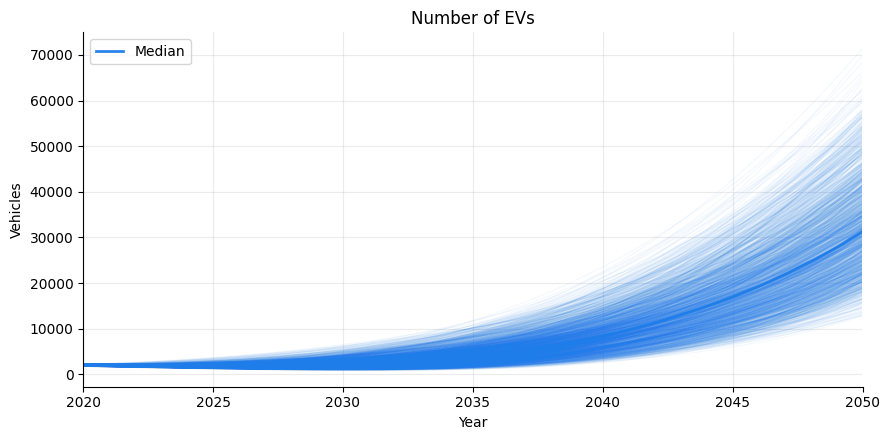

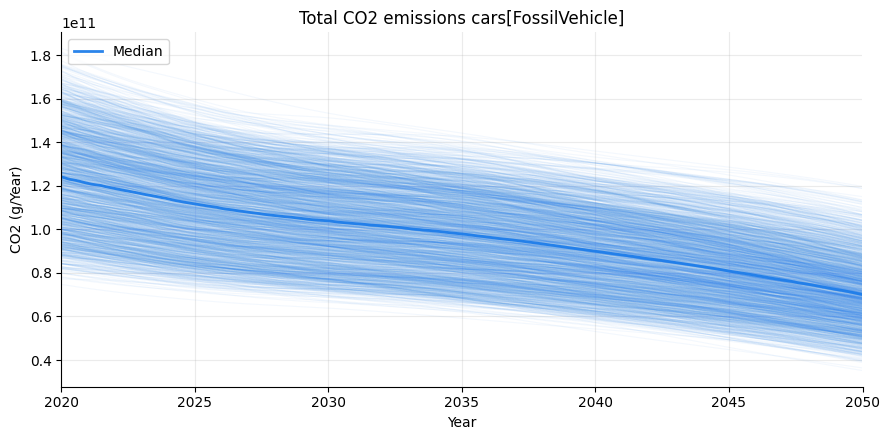

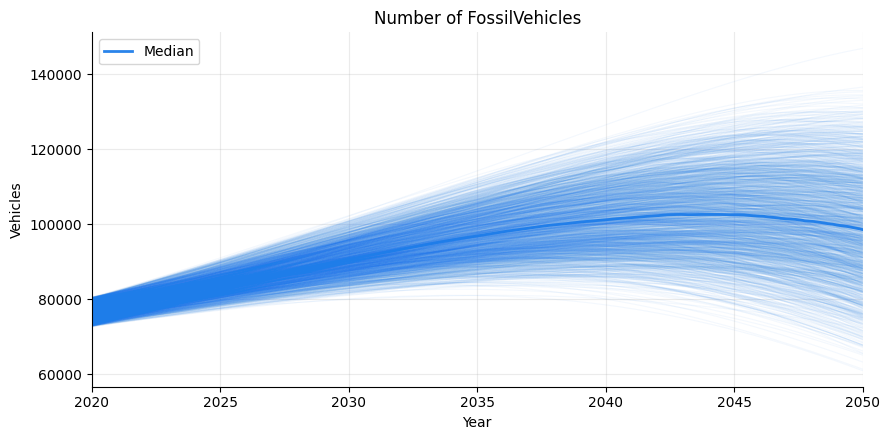

In [6]:
outcomes_of_interest = [
    "Number of EVs",
    "Total CO2 emissions cars[FossilVehicle]",
    "Number of FossilVehicles",
]

# units (adjust if needed)
units = {
    "Number of EVs": "Vehicles",
    "Total CO2 emissions cars[FossilVehicle]": "CO2 (g/Year)",
    "Number of FossilVehicles": "Vehicles",
}

def _make_time_axis_from_outcome(arr):
    T = arr.shape[1]
    for key in ("time", "TIME", "Time"):
        if key in outcomes and getattr(outcomes[key], "ndim", None) == 1 and outcomes[key].shape[0] == T:
            return outcomes[key]
    # default: inclusive years 2020..2050 mapped to T points
    return np.linspace(2020, 2050, T)

def plot_many_runs_same_colour(outcomes, outcome_names,
                               units=None,
                               upsample_factor=8,
                               base_color="#1f77b4",
                               line_alpha=0.03,
                               lw=0.8,
                               show_median=True,
                               figsize=(9, 4.5)):
    """
    Plot each outcome in outcomes_of_interest as an individual figure.
    Lines use the same colour and a low alpha so overlapping areas become brighter.
    Linear interpolation upsamples the series to smooth step-like (rectangular) data.
    """
    for outcome_name in outcome_names:
        if outcome_name not in outcomes:
            print(f"Warning: outcome '{outcome_name}' not found. Skipping.")
            continue

        arr = outcomes[outcome_name]  # expected shape (n_cases, T)
        if arr.ndim != 2:
            raise ValueError(f"Outcome '{outcome_name}' must be 2D (n_cases, T); got {arr.shape}")

        n_cases, T = arr.shape
        time = _make_time_axis_from_outcome(arr)
        # build a finer time axis for interpolation
        fine_T = int(T * upsample_factor)
        fine_time = np.linspace(time[0], time[-1], fine_T)

        fig, ax = plt.subplots(figsize=figsize)

        # plot each run interpolated to fine_time
        for i in range(n_cases):
            y = arr[i, :].astype(float)
            y_fine = np.interp(fine_time, time, y)   # linear interpolation
            ax.plot(fine_time, y_fine, color=base_color, alpha=line_alpha, linewidth=lw, solid_capstyle="round")

        # median overlay
        if show_median:
            median = np.nanmedian(arr, axis=0)
            median_fine = np.interp(fine_time, time, median)
            ax.plot(fine_time, median_fine, color=base_color, linewidth=2.0, alpha=0.95, label="Median")

        ax.set_title(outcome_name)
        ax.set_xlabel("Year")
        ax.set_ylabel(units.get(outcome_name, "Value") if units else "Value")
        ax.set_xlim(2020, 2050)
        ax.set_xticks(np.arange(2020, 2051, 5))
        ax.grid(alpha=0.25)
        if show_median:
            ax.legend(loc="upper left")
        plt.tight_layout()
        sns.despine()
        plt.show()

# Call the improved plotter (adjust parameters if you want different smoothing/alpha)
plot_many_runs_same_colour(outcomes, outcomes_of_interest, units=units,
                           upsample_factor=8, base_color="#1e7de9", line_alpha=0.05, lw=0.8)

**Interpretation of baseline uncertainty runs (n = 1,500, no policy scenario)**

These plots show how key outcomes evolve under full uncertainty without any policy interventions.
<br>

* Number of EVs: EV adoption grows exponentially after 2035 in most runs, but with wide uncertainty bands. This spread shows how sensitive adoption is to parameters like market price, car costs, and charging time.
* Total CO₂ emissions (fossil vehicles): Emissions gradually decline as EVs replace fossil vehicles. The variation across runs reflects differences in fossil fuel efficiency and fleet turnover.
* Number of fossil vehicles: Fossil vehicles initially increase slightly before stabilising or declining after 2040. This indicates that early growth in total vehicle demand can temporarily offset electrification gains.
* Overall, the ensemble shows a clear long-term transition trend toward electrification, but with high uncertainty in the pace and timing of that transition due to interacting factors in the model.

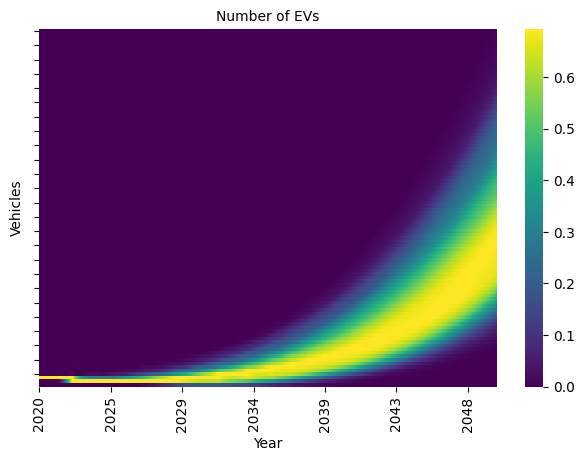

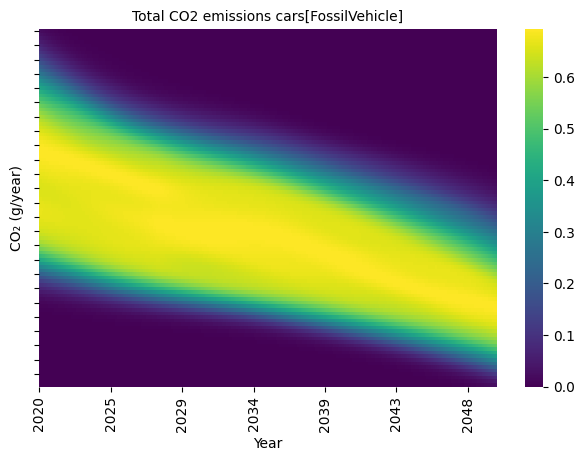

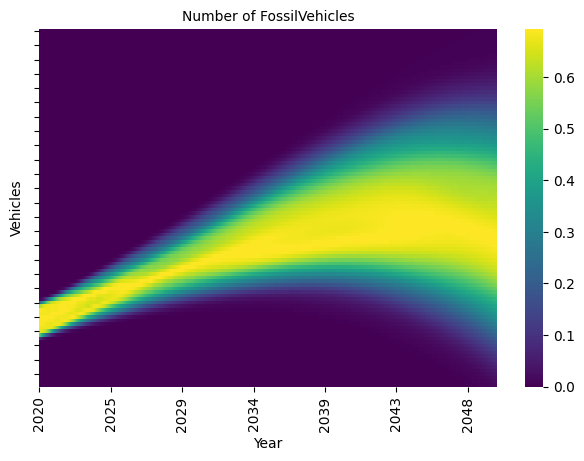

In [68]:
from ema_workbench.analysis import plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

outs = [
    "Number of EVs",
    "Total CO2 emissions cars[FossilVehicle]",
    "Number of FossilVehicles",
]

# your real time range from EMA (already years)
tvec = outcomes["TIME"][0]                 # shape (T,)
start_year, end_year = float(tvec[0]), float(tvec[-1])

units = {
    "Number of EVs": "Vehicles",
    "Total CO2 emissions cars[FossilVehicle]": "CO₂ (g/year)",
    "Number of FossilVehicles": "Vehicles",
}

for outcome in outs:
    fig, axes_map = plotting.kde_over_time(
        experiments, outcomes,
        outcomes_to_show=[outcome],
        colormap="viridis", log=True
    )
    ax = axes_map[outcome]

    # Draw once so limits are known
    fig.canvas.draw()
    xmin, xmax = ax.get_xlim()

    # Linear mapping from the *current* axis scale to calendar years
    def to_year(x):
        return start_year + (x - xmin) * (end_year - start_year) / (xmax - xmin)

    def year_formatter(x, pos):
        return f"{int(round(to_year(x)))}"

    ax.xaxis.set_major_locator(MaxNLocator(nbins=7, integer=False))
    ax.xaxis.set_major_formatter(FuncFormatter(year_formatter))
    ax.set_xlabel("Year")

    ax.set_title(outcome, fontsize=10)
    ax.set_ylabel(units.get(outcome, ""))

    plt.tight_layout(pad=1.4)
    plt.show()


**Interpretation of KDE-over-time plots (n = 1,500, no policy scenario)**

These plots show the probability density of each outcome over time under full uncertainty (no policy interventions applied). The colour intensity indicates where most runs cluster.
* Number of EVs: EV adoption shows a clear exponential growth pattern, with most runs concentrated around higher values after 2040. The widening distribution indicates increasing uncertainty in future adoption rates.
* Total CO₂ emissions (fossil vehicles): Emissions steadily decline as the fossil fleet is gradually replaced by EVs. The narrowing distribution in later years shows convergence towards lower emission levels.
* Number of fossil vehicles: Fossil vehicles initially grow slightly but start to plateau and decline after ~2040. The broadening yellow band reflects uncertainty in how quickly fossil cars are phased out.
* Together, the plots confirm a consistent transition trend: rising EV numbers, declining CO₂ emissions, and stabilising fossil vehicle use — yet with substantial variation in how fast this shift unfolds due to interacting uncertainties in market, cost, and behavioural parameters.

## 3. Random Forest


**Why use Random Forest for variable reduction?**
* Not all 39 variables explain all variance in the end results. For scenario discovery, we need the uncertainties that explain most of the variance.
* Random Forests work well for non-linear and interacting relationships between uncertainties and outcomes. They can handle complex dynamics without needing assumptions about how variables relate.
* Other methods like Sobol sensitivity analysis require thousands of runs and assume a smooth, continuous model, which isn’t practical for simulation-based models like Vensim.
Simpler scoring methods (like correlation) miss interactions and can be misleading.
* So, Random Forest with permutation importance is a computationally efficient and interpretable way to find which uncertainties matter most.

In [8]:
# Pull out the time series from EMA outcomes
ev_ts = np.array(outcomes["Number of EVs"])

# Select the last time step (2050)
ev_final = ev_ts[:, -1]

# Drop non-input columns
X = experiments.drop(columns=["scenario", "policy", "model"], errors="ignore")

# Define target
y = ev_final

In [10]:
# perform RandomForest (impurity and permutation importance)
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# impurity-based quick check
impurity_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features (impurity-based):")
print(impurity_importances.head(15))

# permutation importance (more reliable)
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

print("\nTop features (permutation-based):")
print(perm_importances.head(15))

Top features (impurity-based):
market price scenario switch                 0.266059
beta car price                               0.260499
"Car park growth %"                          0.167511
beta charge time                             0.109392
ASC[FossilVehicle]                           0.042600
beta range                                   0.038515
beta charging distance                       0.011594
initial value facilities[ElectricVehicle]    0.009392
initial value facilities[FossilVehicle]      0.005080
initial total cars                           0.004655
"out of use % 5 to10 yr"[FossilVehicle]      0.004010
"out of use % 20 yr plus"[FossilVehicle]     0.003695
operational                                  0.003676
ASC[ElectricVehicle]                         0.003583
facility ratio[ElectricVehicle]              0.003479
dtype: float64

Top features (permutation-based):
market price scenario switch                 0.626237
beta car price                               0.527576
"

**Why use permutation?**
Permutation importance checks how much the model’s performance drops when a variable is randomly shuffled. If shuffling a variable causes a big drop in accuracy, that variable is important.
We use this method because it’s simple, model-independent, and less biased than feature importance based on how often a variable is used in tree splits.

So, Random Forest with permutation importance is a computationally efficient and interpretable way to find which uncertainties matter most.


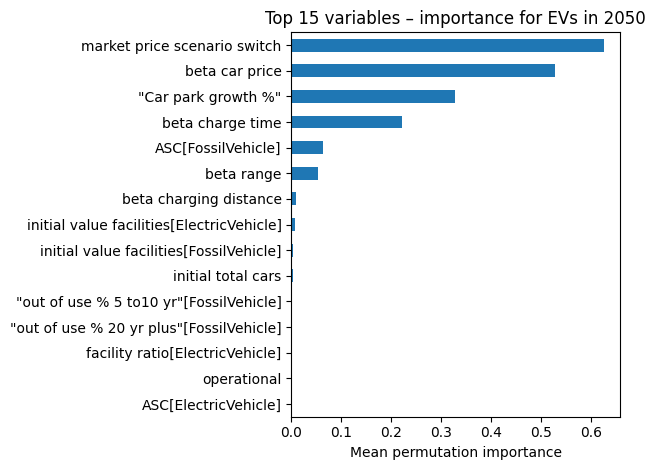

In [11]:
# plot permutation importances
perm_importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 variables – importance for EVs in 2050")
plt.xlabel("Mean permutation importance")
plt.tight_layout()
plt.show()


**Which variables are dropped?**
* The top eight variables explain most of the variation in EV adoption by 2050. These have a clear impact on model performance, while the rest add little explanatory power.
* The two “initial value facilities” variables were excluded because they mainly reflect starting conditions, not dynamic uncertainties driving long-term outcomes. Including them could bias results toward the initial infrastructure setup.
* The variable “initial total cars” was kept, since it affects the overall vehicle stock size and thus the scale of adoption and emissions.
* The final set therefore focuses on behavioural, economic, and policy-related uncertainties—those most relevant for exploring EV transition dynamics.

## 4. Re-Run with fewer uncertainties and policies

In [16]:
# instantiate a model
wd = "./model_files/" # adjust this path to load different version of model
vensim_model = VensimModel("evmodel", wd=wd, model_file="ev_curacao_model.vpmx") # "21-10 ochtend.vpmx" "20-10 eind middag.vpmx"

uncertainties = [
    # ----------------------------
    # Categorical switches
    # ----------------------------
#    CategoricalParameter("Energy price switch", (1, 2, 3)),                         # 1=Stanford, 2=Twente, 3=IET
#    CategoricalParameter("Fuel price switch", (1, 2, 3)),                           # 1=high, 2=medium, 3=low
    CategoricalParameter("market price scenario switch", (0, 1, 2)),                # 0=, 1=, 2=

    # --- Initial conditions Cars/EVs
    IntegerParameter("initial total cars", int(78717*0.95), int(78717*1.05)),       # 78717 ±20%
#    RealParameter("initial share of EV", 0.0254075*0.9, 0.0254075*1.1),             # 

    # --- CO2 initial levels (FossilVehicle only; EV kept constant at 0)
#    RealParameter("initial CO2 0 to 5 yrs[FossilVehicle]", 92, 138),                # 115 ±20%
#    RealParameter("initial CO2 5 to 10 yrs[FossilVehicle]", 120, 180),              # 150 ±20%
#    RealParameter("initial CO2 10 to 15 yrs[FossilVehicle]", 136, 204),             # 170 ±20%
#    RealParameter("initial CO2 15 to 20 yrs[FossilVehicle]", 144, 216),             # 180 ±20%
#    RealParameter("initial CO2 20 yrs plus[FossilVehicle]", 152, 228),              # 190 ±20%

    # --- Prices & costs
#    RealParameter("operational", 0.3129*0.5, 0.3129*1.5),                           # 0.3129 ±50%
#    RealParameter("yearly fee", 343*0.5, 343*1.5),                                  # 343 ±50%
  
    # --- Efficiency / kms driven / growth
#    RealParameter("fuel efficiency", 0.11235*0.8, 0.11235*1.2),                             # (1/8.9) ±20% 
#    RealParameter("Average kms driven anually[FossilVehicle]", 10000*0.7, 10000*1.3),       # 10000 ±20%
#    RealParameter("Average kms driven anually[ElectricVehicle]", 10000*0.7, 10000*1.3),     # 10000 ±20%
    RealParameter('"Car park growth %"', 0.0212*0.5, 0.0212*1.1),                           # 0.0212 -50%, +10%

    # --- Charging infrastructure (constants-only items)
#    RealParameter("initial value facilities[FossilVehicle]", 35*0.9, 35*1.1),       # 35 ±20%
#    RealParameter("initial value facilities[ElectricVehicle]", 32*0.8, 32*1.2),     # 32 ±20%
#    RealParameter("facility ratio[FossilVehicle]", 0.002*0.9, 0.002*1.1),           # 
#    RealParameter("facility ratio[ElectricVehicle]", 0.2*0.5, 0.2*1.1),             # 
#    RealParameter("Facility delay[FossilVehicle]", 1.5*0.7, 1.5*1.3),               # 0.9 ±20%
#    RealParameter("Facility delay[ElectricVehicle]", 0.5*0.7, 1.5*0.7),             # 0.7 ±20%

    # --- Discrete choice (ASC & betas)
    RealParameter("ASC[FossilVehicle]", 0.9*0.8, 0.9*1.2),                          # 0.9 ±20%
#    RealParameter("ASC[ElectricVehicle]", 0.1*0.8, 0.1*1.2),                        # 0.1 ±20%
    RealParameter("beta range", 0.00166, 0.00328),                                  # 95% confidence interval from SDC
    RealParameter("beta charging distance", -0.5, -0.06),                           #  95% confidence interval from SDC
    RealParameter("beta charge time", -0.0021, -0.00041),                           # 95% confidence interval from SDC
#    RealParameter('"beta fuel/charging costs"', -0.00351, -0.00191),                # (-0.271/100) ±20% 
    RealParameter("beta car price", -5.06e-05*1.5, -5.06e-05*0.5),                  # (-7.59e-05, -2.53e-05)
    
    # --- Out-of-use rates (both vehicle types)
#    RealParameter('"out of use % 0 to 5 yr"[FossilVehicle]', 0.0152, 0.0228),       # 0.019 ±20%
#    RealParameter('"out of use % 5 to10 yr"[FossilVehicle]', 0.0184, 0.0276),       # 0.023 ±20%
#    RealParameter('"out of use % 10 to15 yr"[FossilVehicle]', 0.0408, 0.0612),      # 0.051 ±20%
#    RealParameter('"out of use % 15 to 20 yr"[FossilVehicle]', 0.1296, 0.1944),     # 0.162 ±20%
#    RealParameter('"out of use % 20 yr plus"[FossilVehicle]', 0.112, 0.168),        # 0.14 ±20%

#    RealParameter('"out of use % 0 to 5 yr"[ElectricVehicle]', 0.0152, 0.0228),     #
#    RealParameter('"out of use % 5 to10 yr"[ElectricVehicle]', 0.0184, 0.0276),     #
#    RealParameter('"out of use % 10 to15 yr"[ElectricVehicle]', 0.0408, 0.0612),    #
#    RealParameter('"out of use % 15 to 20 yr"[ElectricVehicle]', 0.1296, 0.1944),   #
#    RealParameter('"out of use % 20 yr plus"[ElectricVehicle]', 0.112, 0.168),      #
]

policy_levers = [
    CategoricalParameter("Emission tax SWITCH", (0, 1)),        #
    CategoricalParameter("SWITCH Policy EV Tax Cut", (0, 1)),   #
   CategoricalParameter("Dynaf lever SWITCH", (0, 1, 2)),      # 0=normal,1=high,2=very high
]

# Register on the model
vensim_model.uncertainties = uncertainties #+ policy_levers
vensim_model.levers = policy_levers 

vensim_model.outcomes = [
    TimeSeriesOutcome("Number of EVs"),
    TimeSeriesOutcome("Total CO2 emissions cars[FossilVehicle]"),
    TimeSeriesOutcome("Number of FossilVehicles"),
    ]
 
# RUN THE EXPERIMENTS
results = perform_experiments(vensim_model, 
                              scenarios=200,
                              policies=12
                              )

# split results into experiments and outcomes
experiments, outcomes = results

[MainProcess/INFO] performing 200 scenarios * 12 policies * 1 model(s) = 2400 experiments
  0%|                                                 | 0/2400 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially


100%|██████████████████████████████████████| 2400/2400 [01:30<00:00, 26.40it/s]
[MainProcess/INFO] experiments finished


In [69]:
#experiments.head()

In [ ]:
# Save results  
#save_results(results, "./results/results_PRIM_WITH_POLICY.tar.gz")

c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_PRIM_WITH_POLICY.tar.gz


In [70]:
# Load results
experiments, outcomes = load_results("./results/results_PRIM_WITH_POLICY.tar.gz")

[MainProcess/INFO] results loaded successfully from c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_PRIM_WITH_POLICY.tar.gz


### Initial Exploration

C:\Users\Amber Rozenberg\AppData\Local\Temp\ipykernel_8504\3169163440.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
C:\Users\Amber Rozenberg\AppData\Local\Temp\ipykernel_8504\3169163440.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend


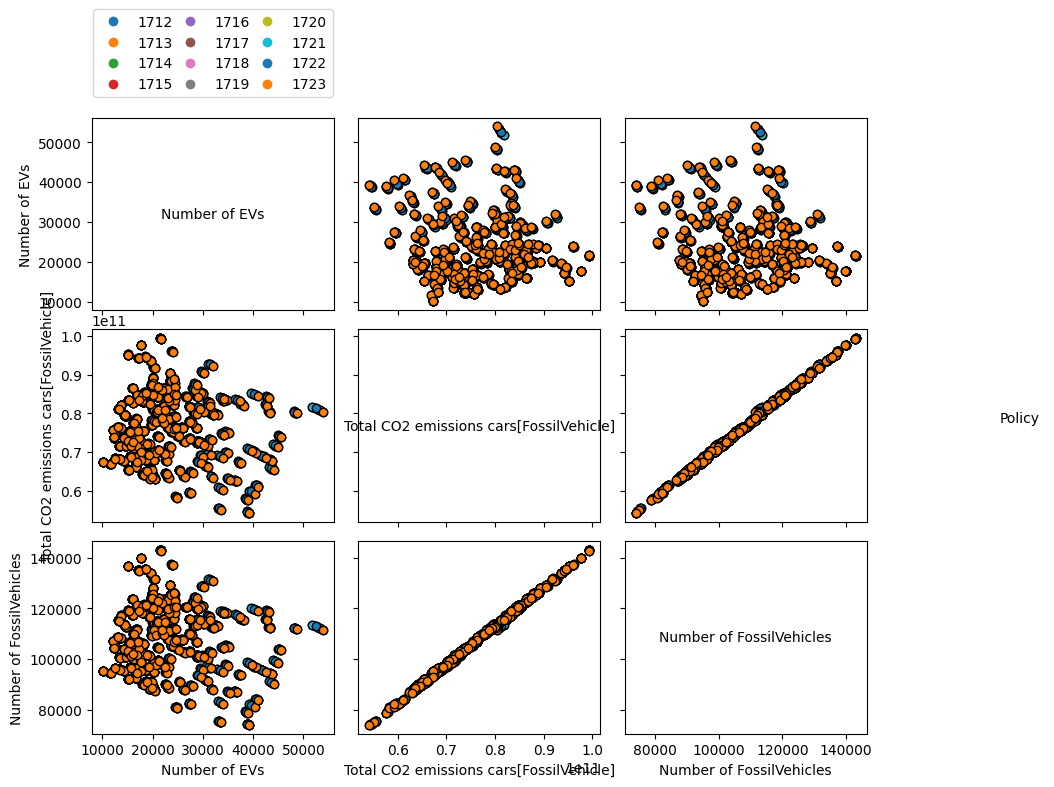

In [27]:
# Initial Exploration, colour-coded by policy?
fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, legend=True, group_by='policy', 
    alpha=0.3, s=10,
)
fig.set_size_inches(8, 8)

fig.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    title='Policy',
    frameon=False,
)
fig.set_size_inches(10, 8)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend

plt.show()

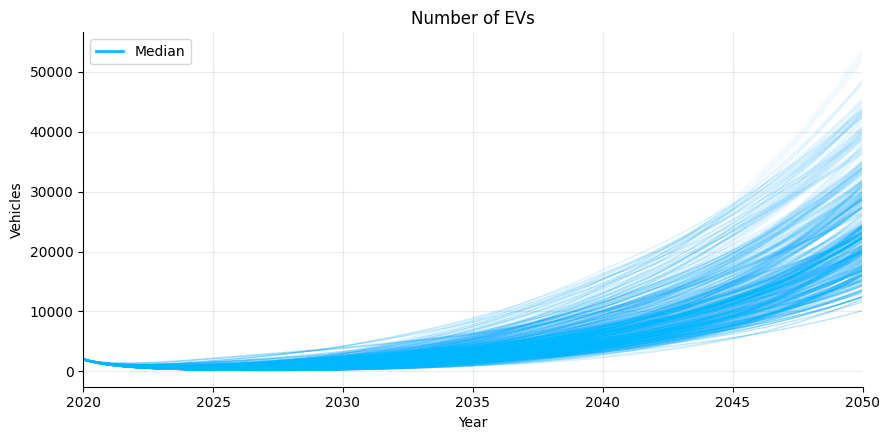

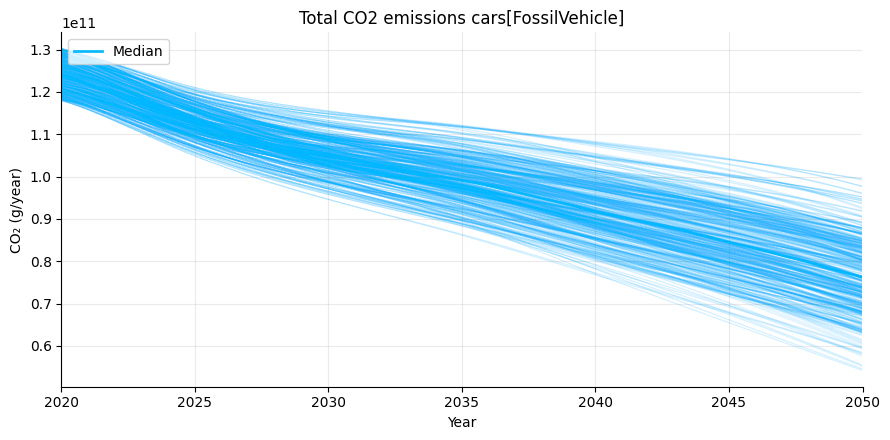

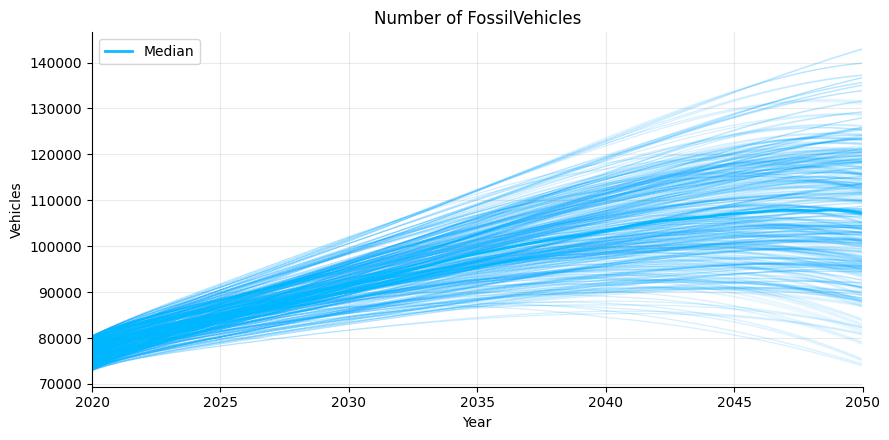

In [71]:
# plot the outcomes of interest as line graphs
plot_many_runs_same_colour(outcomes, outcomes_of_interest, units=units,
                           upsample_factor=8, base_color="#00B7FF9E", line_alpha=0.03, lw=0.8)

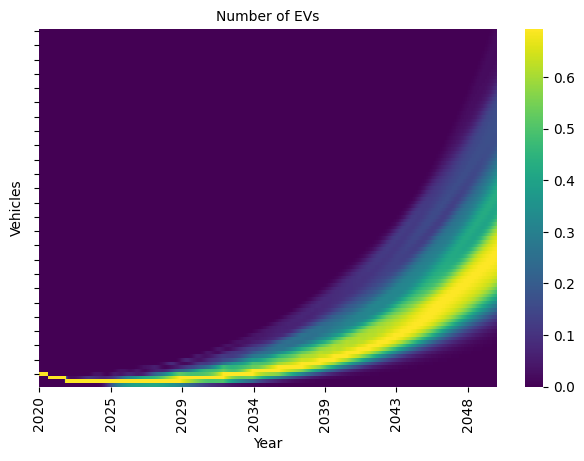

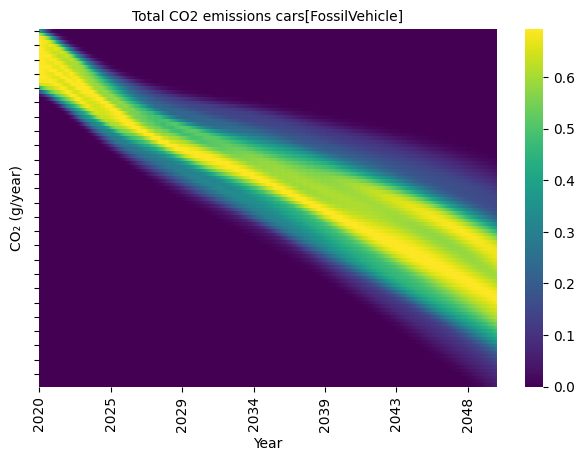

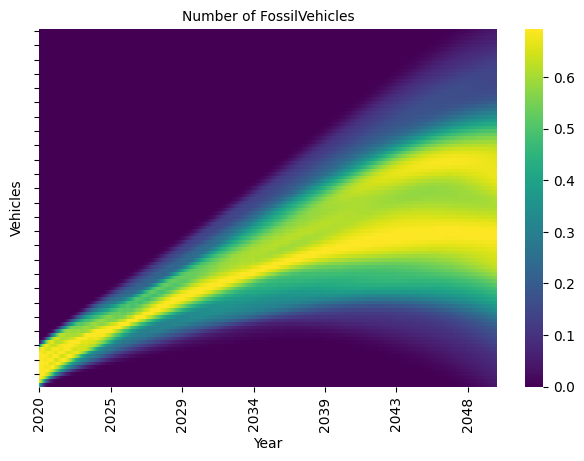

In [72]:
outs = [
    "Number of EVs",
    "Total CO2 emissions cars[FossilVehicle]",
    "Number of FossilVehicles",
]

# your real time range from EMA (already years)
tvec = outcomes["TIME"][0]                 # shape (T,)
start_year, end_year = float(tvec[0]), float(tvec[-1])

units = {
    "Number of EVs": "Vehicles",
    "Total CO2 emissions cars[FossilVehicle]": "CO₂ (g/year)",
    "Number of FossilVehicles": "Vehicles",
}

for outcome in outs:
    fig, axes_map = plotting.kde_over_time(
        experiments, outcomes,
        outcomes_to_show=[outcome],
        colormap="viridis", log=True
    )
    ax = axes_map[outcome]

    # Draw once so limits are known
    fig.canvas.draw()
    xmin, xmax = ax.get_xlim()

    # Linear mapping from the *current* axis scale to calendar years
    def to_year(x):
        return start_year + (x - xmin) * (end_year - start_year) / (xmax - xmin)

    def year_formatter(x, pos):
        return f"{int(round(to_year(x)))}"

    ax.xaxis.set_major_locator(MaxNLocator(nbins=7, integer=False))
    ax.xaxis.set_major_formatter(FuncFormatter(year_formatter))
    ax.set_xlabel("Year")

    ax.set_title(outcome, fontsize=10)
    ax.set_ylabel(units.get(outcome, ""))

    plt.tight_layout(pad=1.4)
    plt.show()


## 5. Scenario Discovery

### Patient-Rule Induction Method (PRIM)

#### LOW EV SCENARIO

In [74]:
x = experiments

ev_ts = outcomes["Number of EVs"]
final_evs = ev_ts[:, -1] # pick the last time step (or the column == 30 if your columns are time labels)

cutoff_lo = np.percentile(final_evs, 20)   # 20th percentile
y = final_evs < cutoff_lo                  # explicitly asking PRIM to find combinations of inputs that characterise low EV adoption scenarios.

In [75]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 2400 points remaining, containing 480 cases of interest
[MainProcess/INFO] mean: 0.95, mass: 0.1, coverage: 0.475, density: 0.95 restricted_dimensions: 5


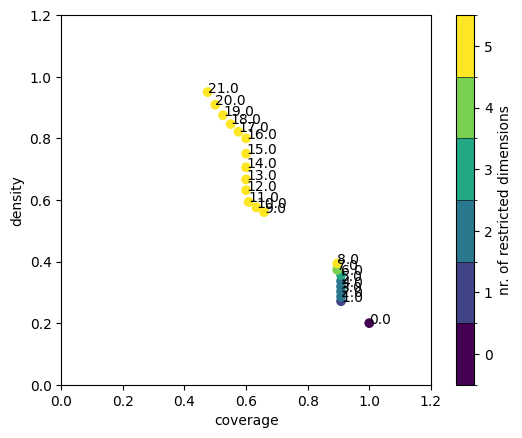

In [76]:
box1.show_tradeoff(annotated=True)
plt.show()

**Trade-off plot:**
* This plot visualises the trade-off between coverage (how much of the low-EV adoption cases are captured) and density (how pure those cases are). Each numbered point represents a potential PRIM box, with colour indicating how many uncertainties are constrained in that box.
* The “elbow” around boxes 15–18 marks a good balance — these boxes capture a large portion of low-EV scenarios while maintaining high internal consistency. Beyond that point, increasing density further would require sharply reducing coverage.

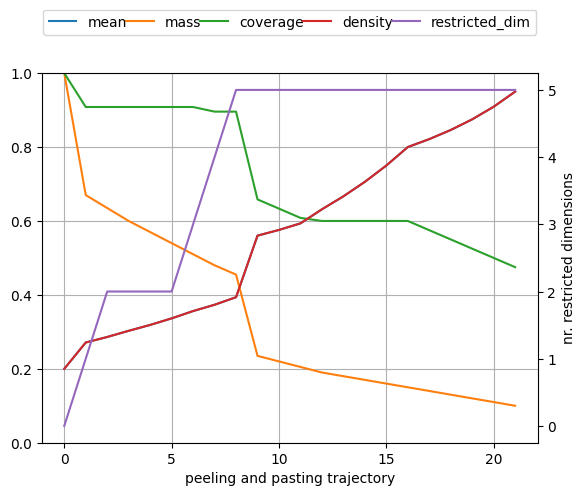

In [77]:
box1.show_ppt() ;

**Peeling and pasting trajectory**
* This figure shows how PRIM gradually narrows down the uncertainty space to isolate the conditions that lead to low EV adoption in 2050.
As the algorithm “peels,” mass (box size) decreases and density increases, meaning the subset becomes smaller but more representative of low-EV outcomes. The number of restricted dimensions rises as more uncertainties (e.g., car price sensitivity, market scenario, charging time) are fixed to specific ranges.
* The selected box (e.g. Box 16) therefore represents the most meaningful combination of uncertainty conditions explaining where and why EV adoption remains low by 2050.

''

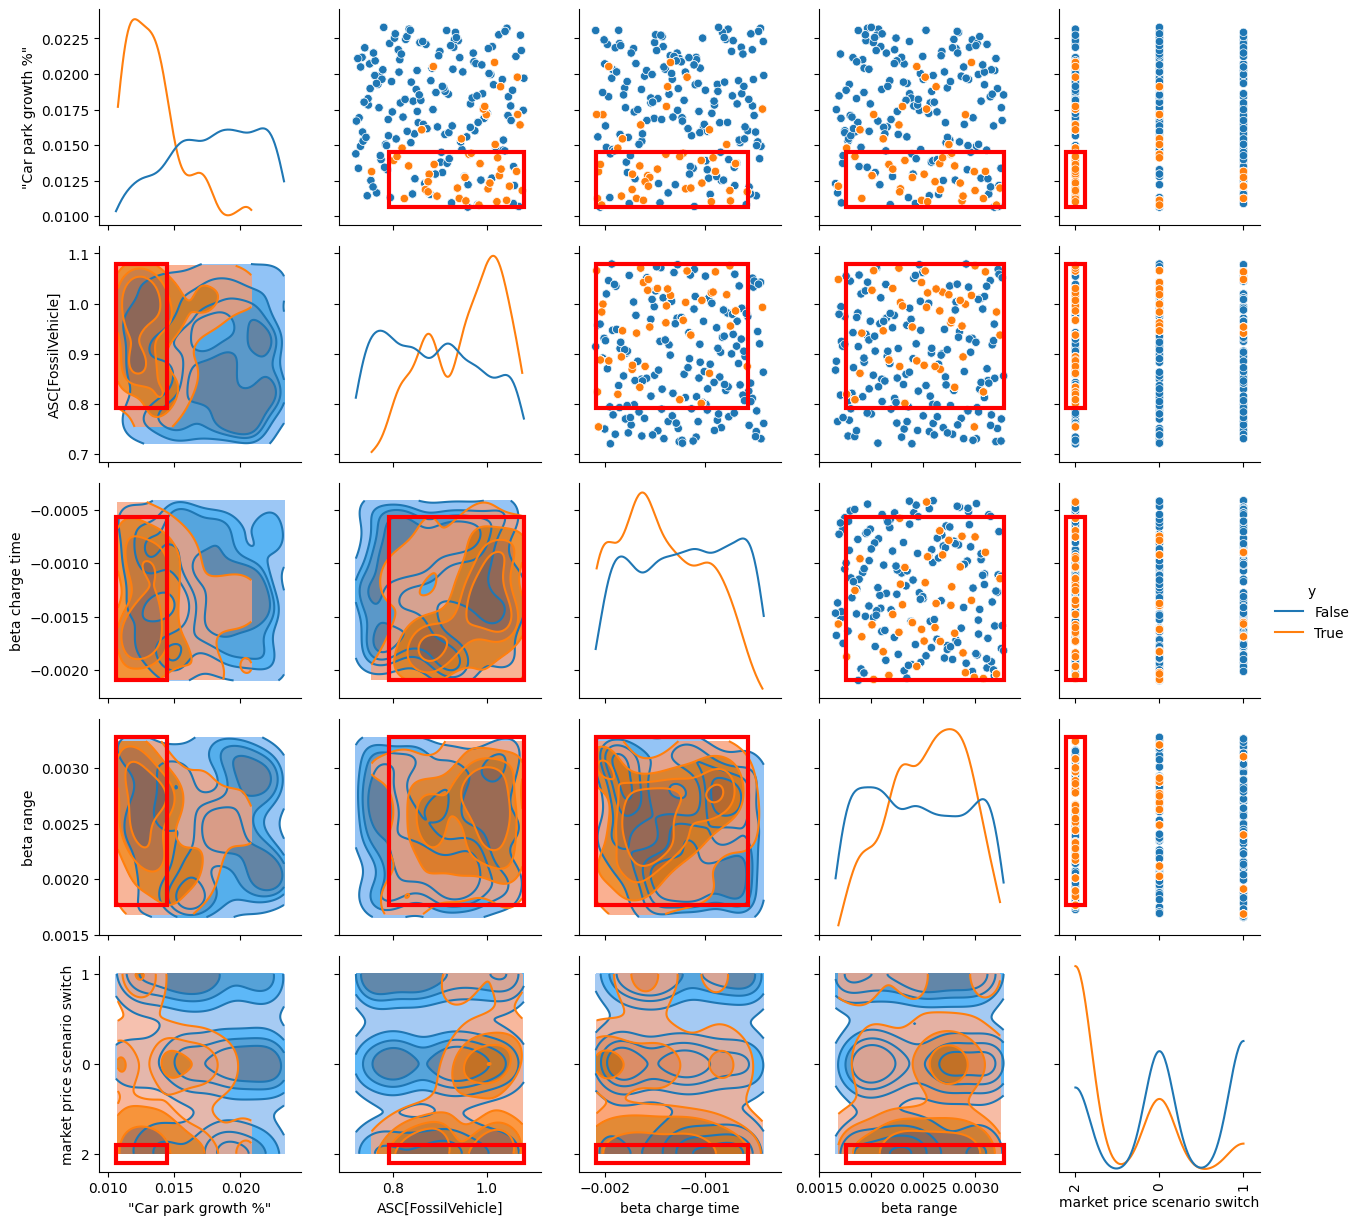

In [78]:
# Scatter plot of box boundaries, for n=2400 takes ~ 1 min
box1.show_pairs_scatter()        # visualize relationships inside/outside box
;

**Interpretation of PRIM box for low EV adoption in 2050**

This pairwise plot visualises the relationships between key uncertainties identified by PRIM and the subset of experiments (orange) that lead to low EV adoption by 2050. The red boxes indicate the boundaries of the final PRIM box (e.g. Box 16).

* Car park growth (%): Low EV adoption is associated with lower overall car park growth, meaning total demand for new vehicles is limited.
* ASC [FossilVehicle]: Higher attractiveness of fossil vehicles (positive ASC) strongly correlates with low EV uptake.
* Beta charge time: More negative values (stronger sensitivity to charging duration) correspond to reduced EV adoption, indicating that long charging times discourage consumers.
* Beta range: Low EV range sensitivity (around 0.002–0.003) appears linked to low adoption, suggesting limited concern for range is not enough to overcome other barriers.
* Market price scenario switch: Low adoption is concentrated in scenario 2 (the high-price or unfavourable market scenario), confirming that macroeconomic context matters strongly.
* Overall, the plot shows how market conditions and behavioural sensitivities combine to define the “problematic” region where EV penetration remains low by 2050 — supporting the variables highlighted as key drivers in the permutation importance and PRIM trade-off analyses.

[<Figure size 640x480 with 1 Axes>]

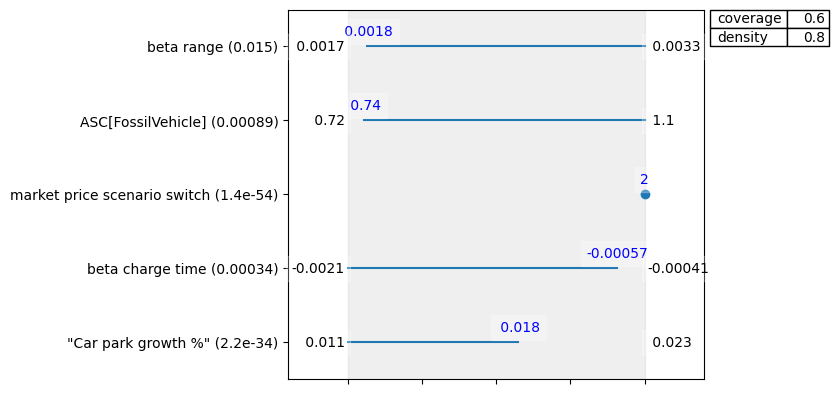

In [79]:
#box1.inspect(16)
box1.inspect(16, style='graph')

**Interpretation**
* coverage = 0.6, Density = 0.8 → Good balance: captures 60% of low-EV cases with 80% purity.

Restricted variables:

* β range (0.0017–0.0033)
→ EV adoption is low when the sensitivity to driving range is weak — i.e. consumers don’t value range strongly.

* ASC[FossilVehicle] (0.72–1.1)
→ High positive ASC for fossil vehicles — meaning ICE cars are generally more preferred.

* market price scenario switch = 2
→ This discrete variable = likely a high-price or unfavourable market scenario.

* β charge time (-0.0021 to -0.00057)
→ Low absolute effect of charge time — people not penalising charging delay strongly (or in other words, EV inconvenience is not mitigated).

* Car park growth % (0.011–0.023)
→ Relatively high growth in total vehicles, meaning fast expansion of the fleet where EV share stays small.

**Interpretation for stakeholder**

Low EV adoption occurs in model when:

* ICEs remain relatively attractive (ASC[FossilVehicle] high),
* range matters little to consumers (β range small),
* charging time penalty is small (β charge time close to zero → limited sensitivity to charging inconvenience),
* total car park is expanding fast (growth 1.1–2.3%),
* and this happens mainly under market scenario 2.


"The PRIM analysis reveals that low EV adoption occurs primarily when internal-combustion vehicles retain a high intrinsic preference (ASC[FossilVehicle] > 0.7), consumers place limited importance on EV range and charging time (β range ≈ 0.002, β charge time ≈ −0.001), and the vehicle fleet grows rapidly (1.1–2.3 %/yr), particularly under market price scenario 2.
Box 16 (coverage = 0.6, density = 0.8) offers the best trade-off between explanatory power and representativeness.[EXPLAIN WHY]"

#### HIGH EV SCENARIO

In [80]:
x = experiments

ev_ts = outcomes["Number of EVs"]
final_evs = ev_ts[:, -1] # pick the last time step (or the column == 30 if your columns are time labels)

cutoff_hi = np.percentile(final_evs, 80)   # 20th percentile
y = final_evs > cutoff_hi                  # explicitly asking PRIM to find combinations of inputs that characterise low EV adoption scenarios.

In [81]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 2400 points remaining, containing 480 cases of interest
[MainProcess/INFO] mean: 0.88, mass: 0.08333333333333333, coverage: 0.36666666666666664, density: 0.88 restricted_dimensions: 8


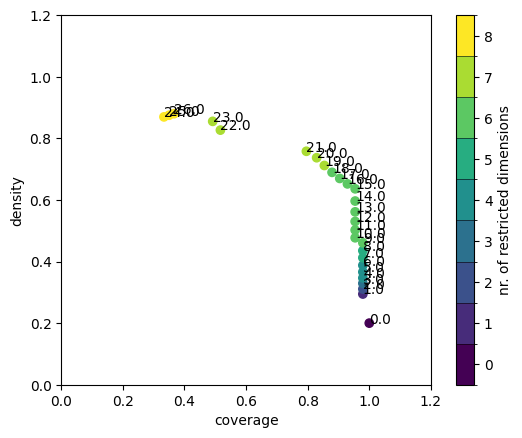

In [82]:
box1.show_tradeoff(annotated=True)
plt.show()

**Trade-off plot**
* The plot shows the trade-off between coverage (how much of the high-EV cases are captured) and density (how pure those cases are). Each numbered point represents a potential PRIM box, with colour indicating how many uncertainties are constrained.
* The curve’s elbow around boxes 21–24 indicates the best balance between capturing a large share of high-EV outcomes and maintaining high density. Boxes beyond this point yield only minor improvements in purity at the cost of coverage.

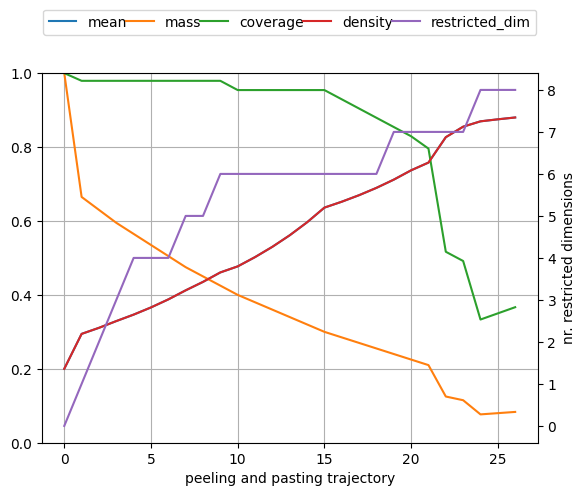

In [83]:
box1.show_ppt() ;

**Peeling and pasting trajectory**

* As the algorithm iteratively narrows the space, mass (size of the box) decreases while density and restricted dimensions increase — showing that high-EV scenarios are characterised by increasingly specific combinations of uncertainty values.
* The stable or slightly declining coverage line reflects that the identified box still represents a significant share of high-EV outcomes.
* The selected box (e.g. Box 22 or 23) therefore represents the favourable conditions under which EV adoption reaches the upper trajectories by 2050, typically combining strong market incentives, low car prices, short charging times, and a favourable price scenario.

''

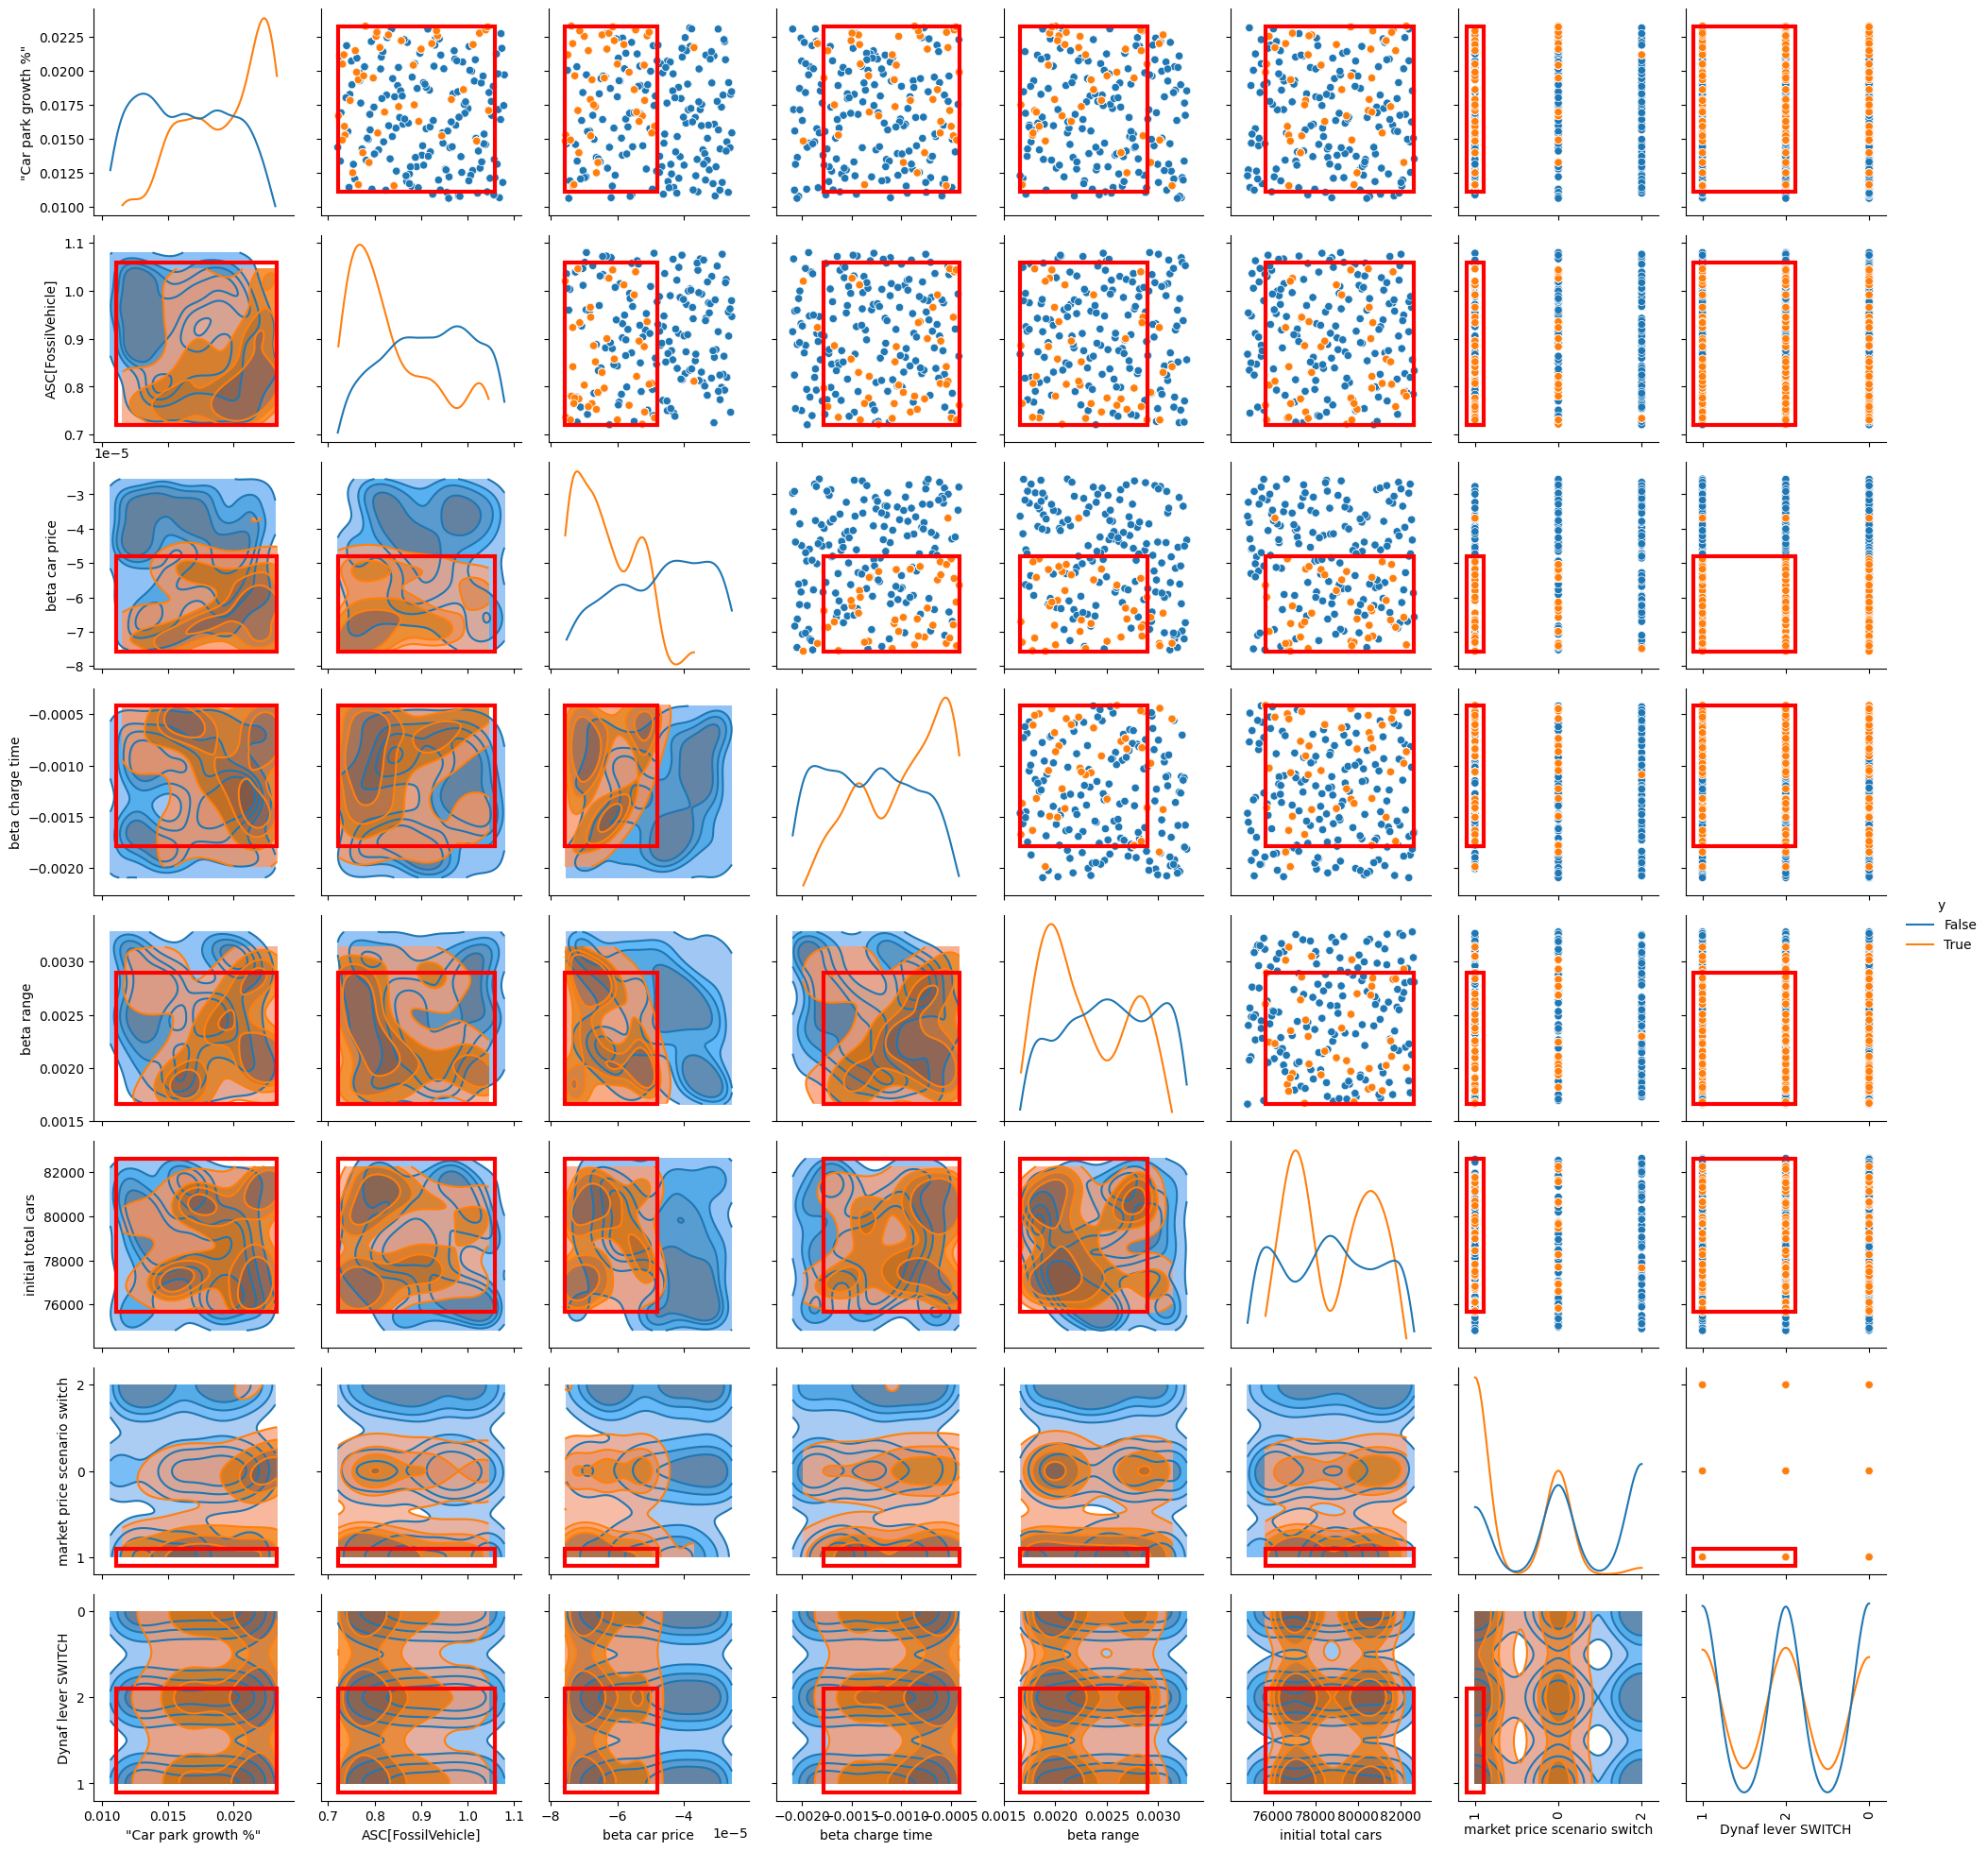

In [84]:
# Scatter plot of box boundaries, for n=2400 takes ~ 1 min
box1.show_pairs_scatter()        # visualize relationships inside/outside box
;

**Interpretation of PRIM box for high EV adoption in 2050**

This pairwise scatter and density plot shows the interactions between the key uncertainties in the high EV adoption region (orange). The red boxes represent the boundaries of the final PRIM box (e.g. Box 22 or 23) that characterises the conditions leading to strong EV growth by 2050.

* Car park growth (%): High EV adoption occurs when overall car park growth is moderate to high, providing market space for EV uptake.
* ASC [FossilVehicle]: Low fossil vehicle attractiveness (lower ASC) strongly supports EV diffusion, showing the behavioural shift away from fossil technologies.
* Beta car price: Less negative values indicate lower consumer sensitivity to EV price differences — suggesting EVs are more accepted even when costly.
* Beta charge time: Weaker negative values (less sensitivity to charging delay) favour EV adoption, as consumers are less discouraged by charging duration.
* Beta range: Higher values within the selected box correspond to stronger preference for vehicles with greater range, reinforcing adoption when EV range improves.
* Market price scenario switch: Most high-EV runs occur under the favourable market scenario (switch = 1), confirming the importance of macroeconomic conditions.
* Dynaf lever SWITCH: The active policy lever (Dynaf = 1) is consistently part of the high-adoption subset, indicating that supportive interventions further amplify uptake.
* Overall, the figure shows that high EV adoption by 2050 emerges from a combination of favourable market conditions, supportive policies, and reduced behavioural barriers related to price and charging — mirroring the drivers identified in the permutation importance analysis.

**Note:**
The Dynaf lever SWITCH appears in the pairwise plots because it was included as an uncertainty in the PRIM analysis. However, it does not show up in the Box 22 results since PRIM did not restrict this variable — meaning that constraining its value did not improve the explanation of high EV adoption. In other words, Dynaf supports EV uptake but is not a defining condition for the high-adoption region.

[<Figure size 640x480 with 1 Axes>]

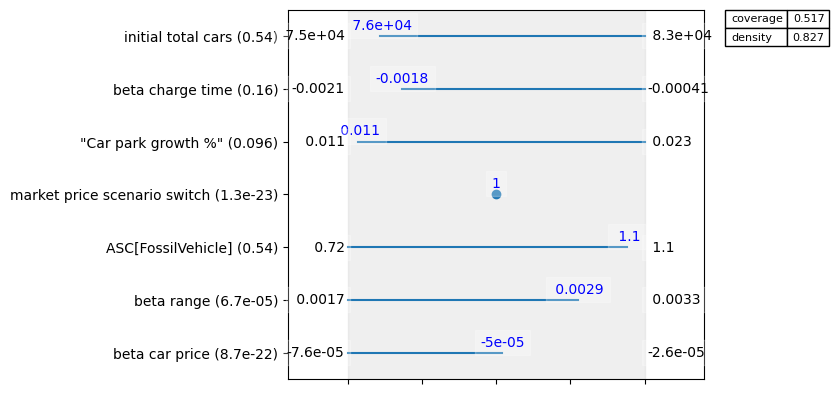

In [85]:
# insoect the 'elbow' box
#box1.inspect(22)
box1.inspect(22, style='graph')

**Interpretation**
Coverage = 0.52, Density = 0.83 → Good balance: the box captures ≈ 52 % of all high-EV cases with ≈ 83 % purity.

Restricted variables:
* β car price (–7.6 × 10⁻⁵ to –2.6 × 10⁻⁵)
→ Consumers are relatively insensitive to purchase price; price differences no longer strongly affect EV adoption.
* β range (0.0017 – 0.0029)
→ High sensitivity to range — people value driving range strongly, so improvements in range have a big positive impact.
* ASC [FossilVehicle] (0.72 – 1.10)
→ Internal-combustion vehicles remain acceptable but are not overwhelmingly preferred, leaving room for EV uptake.
* Market price scenario switch = 1
→ High EV adoption occurs mainly under a favourable market scenario (e.g. stable prices, supportive policy climate).
* Car park growth % (0.011 – 0.023)
→ Moderate fleet growth — the total number of vehicles increases, but EVs gain a large share within that expansion.
* β charge time (–0.0018 – –0.0004)
→ Moderate disutility for charging time — consumers dislike long charging, yet infrastructure is sufficient to keep it manageable.
* Initial total cars (7.6 × 10⁴ – 8.3 × 10⁴)
→ High adoption emerges in markets that already have a relatively large vehicle base, suggesting maturity and readiness to scale EVs.

**Interpretation for stakeholders**
* High EV adoption occurs in the model when:
* Market conditions are favourable (scenario 1),
* Consumers value driving range strongly (β range high),
* Price sensitivity is low (β car price weak),
* Charging inconvenience is tolerable thanks to adequate infrastructure,
* ICE cars are no longer heavily preferred, and
* The vehicle fleet grows steadily (≈ 1.1 – 2.3 % per year).

""The PRIM analysis reveals that widespread EV uptake emerges under supportive market conditions where consumers trust EV technology and charging reliability. Price incentives play a secondary role once these fundamentals are in place.
Box 22 (coverage ≈ 0.52, density ≈ 0.83) offers the best trade-off between explanatory power and representativeness: it explains a large share of high-adoption outcomes while remaining general enough to describe realistic, policy-relevant conditions.""

Why this box was chosen:
Box 22 strikes the balance between coverage (capturing over half of all high-EV cases) and density (limited false positives). Later boxes (e.g. 23–26) gain little additional purity but lose too much generality, describing only a narrow subset of runs.

### Plot some nice lines on scenarios we found in PRIM

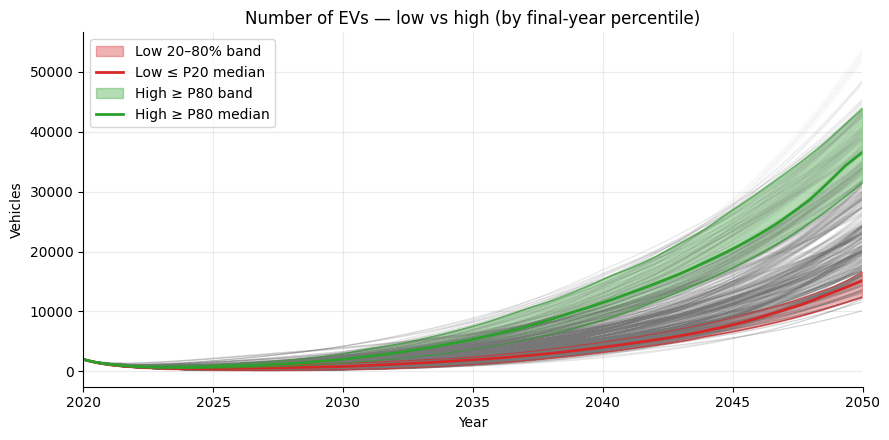

In [54]:
# --- helper from your code ---
def _make_time_axis_from_outcome(arr):
    T = arr.shape[1]
    for key in ("time", "TIME", "Time"):
        if key in outcomes and getattr(outcomes[key], "ndim", None) == 1 and outcomes[key].shape[0] == T:
            return outcomes[key]
    return np.linspace(2020, 2050, T)

def plot_ev_low_high_percentiles(outcomes,
                                 outcome_name="Number of EVs",
                                 low_q=20, high_q=80,
                                 upsample_factor=8,
                                 show_bands=True,
                                 band_quantiles=(10, 90),
                                 all_runs_alpha=0.03,
                                 all_runs_lw=0.7,
                                 low_colour="#d62728",   # red-ish
                                 high_colour="#2ca02c",  # green-ish
                                 median_lw=2.0,
                                 figsize=(9, 4.5)):
    """
    Plot EV adoption with low/high groups (based on final-year EV count) in different colours.
    - low group: runs with final EVs <= low_q percentile
    - high group: runs with final EVs >= high_q percentile
    """
    if outcome_name not in outcomes:
        raise KeyError(f"Outcome '{outcome_name}' not found in outcomes dict")

    arr = outcomes[outcome_name]                     # shape (n_cases, T)
    if arr.ndim != 2:
        raise ValueError(f"'{outcome_name}' must be 2D (n_cases, T); got {arr.shape}")

    n_cases, T = arr.shape
    time = _make_time_axis_from_outcome(arr)

    # define low/high groups by FINAL time step (same as PRIM)
    final_vals = arr[:, -1].astype(float)
    low_cut  = np.percentile(final_vals, low_q)
    high_cut = np.percentile(final_vals, high_q)
    low_mask  = final_vals <= low_cut
    high_mask = final_vals >= high_cut

    # interpolation grid
    fine_T = int(T * upsample_factor)
    fine_time = np.linspace(time[0], time[-1], fine_T)

    # helper to upsample an array of runs (N,T) -> (N,fine_T)
    def _interp_runs(A):
        Y = np.empty((A.shape[0], fine_T), dtype=float)
        for i in range(A.shape[0]):
            Y[i] = np.interp(fine_time, time, A[i].astype(float))
        return Y

    A_all  = _interp_runs(arr)
    A_low  = _interp_runs(arr[low_mask, :])
    A_high = _interp_runs(arr[high_mask, :])

    # percentile bands per group (optional)
    def _band(Y, qlo, qhi):
        return (np.nanpercentile(Y, qlo, axis=0), np.nanpercentile(Y, qhi, axis=0))

    fig, ax = plt.subplots(figsize=figsize)

    # faint background of all runs (grey)
    for i in range(A_all.shape[0]):
        ax.plot(fine_time, A_all[i], color="#777777", alpha=all_runs_alpha, 
                linewidth=all_runs_lw)

    # LOW group band + median
    if show_bands and A_low.shape[0] > 0:
        lo_band, hi_band = _band(A_low, band_quantiles[0], band_quantiles[1])
        ax.fill_between(fine_time, lo_band, hi_band, alpha=0.35, step=None, color=low_colour, 
                        label=f"Low {low_q}–{100-low_q}% band", zorder=1)  # added here
        
        # outline the band to increase contrast
        ax.plot(fine_time, lo_band, color=low_colour, linewidth=0.8, alpha=0.7, zorder=2)
        ax.plot(fine_time, hi_band, color=low_colour, linewidth=0.8, alpha=0.7, zorder=2)


    if A_low.shape[0] > 0:
        low_med = np.nanmedian(A_low, axis=0)
        ax.plot(fine_time, low_med, color=low_colour, linewidth=median_lw, 
                label=f"Low ≤ P{low_q} median")

    # HIGH group band + median
    if show_bands and A_high.shape[0] > 0:
        lo_band_h, hi_band_h = _band(A_high, band_quantiles[0], band_quantiles[1])
        ax.fill_between(fine_time, lo_band_h, hi_band_h, alpha=0.35, step=None, 
                        color=high_colour, label=f"High ≥ P{high_q} band")
        
        # outline the band to increase contrast
        ax.plot(fine_time, lo_band_h, color=high_colour, linewidth=0.8, alpha=0.7, zorder=2)
        ax.plot(fine_time, hi_band_h, color=high_colour, linewidth=0.8, alpha=0.7, zorder=2)


    if A_high.shape[0] > 0:
        high_med = np.nanmedian(A_high, axis=0)
        ax.plot(fine_time, high_med, color=high_colour, linewidth=median_lw, 
                label=f"High ≥ P{high_q} median")

    # styling
    ax.set_title(f"{outcome_name} — low vs high (by final-year percentile)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Vehicles")
    ax.set_xlim(time[0], time[-1])
    try:
        ax.set_xticks(np.arange(2020, 2051, 5))
    except Exception:
        pass
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left")
    sns.despine()
    plt.tight_layout()
    plt.show()

# --- call for EV adoption, using your same outcome dict ---
plot_ev_low_high_percentiles(outcomes,
                             outcome_name="Number of EVs",
                             low_q=20, high_q=80,
                             upsample_factor=8,
                             show_bands=True)


**⚪ Grey lines**

* All 2 400 model runs — every unique combination of uncertainty and policy you explored.
* They show the full variability of possible EV trajectories (2020–2050).

**🔴 Red band + line**

* Subset: the lowest 20 % of final-year EV outcomes (the low-adoption scenarios you used for PRIM).

* Red line: median EV trajectory within that subset.

* Light red band: 10th–90th percentile range within that subset → captures variability inside low-EV cases.
So it’s not the overall 20–80 % of all data, but the internal spread among the bottom quintile.

**🟢 Green band + line**

* Subset: the highest 20 % of final-year EV outcomes (the high-adoption scenarios used in your second PRIM).

* Green line: median EV trajectory of these top performers.

**What do the lines and colours mean?**
* The width of each band = variability within the group → more width means internal heterogeneity.
* The gap between bands = difference between structural futures 
* You can directly link the PRIM boxes to these coloured groups:
*  Red ↔ conditions like high ASC[FossilVehicle], unfavourable market (Box 16).
* Green ↔ favourable market, strong β range, low price sensitivity (Box 22).

**Interpretation**
* The vertical distance between the green and red medians shows how much the future adoption paths diverge by 2050 — a measure of the uncertainty or scenario spread.
* Early years (2020–2030) overlap strongly → the system behaves similarly at first, independent of assumptions.
* Around 2030–2040, the bands separate — that’s when different parameter/policy combinations start to have strong effects (e.g. policy switches, consumer preferences, infrastructure growth).
* By 2045–2050, trajectories differ dramatically: the red group flattens at low adoption, while the green group accelerates exponentially.
→ That’s the emergence of structurally different futures your PRIM boxes describe.

**For Report**
igure X compares the evolution of EV adoption for the lower and upper 20 % of outcomes.
Until roughly 2030, trajectories are similar across runs, indicating limited sensitivity to parameter and policy differences in the early phase of diffusion.
From 2035 onward, scenarios diverge: in the low-adoption group (red), growth remains modest and plateaus below ~10 000 vehicles, whereas the high-adoption group (green) continues rising sharply, reaching over 40 000 vehicles by 2050.
The shaded bands represent the internal uncertainty within each group (10th–90th percentile). Their widening over time reflects increasing divergence among plausible futures.

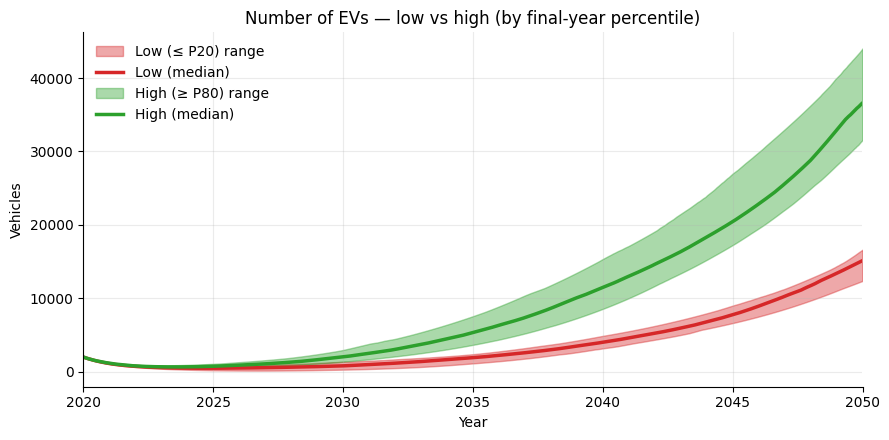

In [ ]:
# some more nice plots for the report and presentation

def plot_ev_low_high_percentiles(outcomes,
                                 outcome_name="Number of EVs",
                                 low_q=20, high_q=80,
                                 upsample_factor=8,
                                 show_bands=True,
                                 band_quantiles=(10, 90),
                                 low_colour="#d62728",   # red-ish
                                 high_colour="#2ca02c",  # green-ish
                                 median_lw=2.5,
                                 figsize=(9, 4.5)):
    """
    Plot EV adoption with low/high groups (based on final-year EV count) in different colours.
    This version highlights the percentile bands clearly and removes background lines.
    """
    if outcome_name not in outcomes:
        raise KeyError(f"Outcome '{outcome_name}' not found in outcomes dict")

    arr = outcomes[outcome_name]                     # shape (n_cases, T)
    if arr.ndim != 2:
        raise ValueError(f"'{outcome_name}' must be 2D (n_cases, T); got {arr.shape}")

    n_cases, T = arr.shape
    time = outcomes["TIME"][0] if "TIME" in outcomes else np.linspace(2020, 2050, T)

    # define low/high groups by FINAL time step
    final_vals = arr[:, -1].astype(float)
    low_cut  = np.percentile(final_vals, low_q)
    high_cut = np.percentile(final_vals, high_q)
    low_mask  = final_vals <= low_cut
    high_mask = final_vals >= high_cut

    # interpolation grid
    fine_T = int(T * upsample_factor)
    fine_time = np.linspace(time[0], time[-1], fine_T)

    # helper to upsample an array of runs (N,T) -> (N,fine_T)
    def _interp_runs(A):
        Y = np.empty((A.shape[0], fine_T), dtype=float)
        for i in range(A.shape[0]):
            Y[i] = np.interp(fine_time, time, A[i].astype(float))
        return Y

    A_low  = _interp_runs(arr[low_mask, :])
    A_high = _interp_runs(arr[high_mask, :])

    def _band(Y, qlo, qhi):
        return (np.nanpercentile(Y, qlo, axis=0), np.nanpercentile(Y, qhi, axis=0))

    fig, ax = plt.subplots(figsize=figsize)

    # LOW group band + median
    if show_bands and A_low.shape[0] > 0:
        lo_band, hi_band = _band(A_low, band_quantiles[0], band_quantiles[1])
        ax.fill_between(fine_time, lo_band, hi_band, alpha=0.4, color=low_colour, 
                        label=f"Low (≤ P{low_q}) range")
        ax.plot(fine_time, np.nanmedian(A_low, axis=0), color=low_colour,
                linewidth=median_lw, label=f"Low (median)")

    # HIGH group band + median
    if show_bands and A_high.shape[0] > 0:
        lo_band_h, hi_band_h = _band(A_high, band_quantiles[0], band_quantiles[1])
        ax.fill_between(fine_time, lo_band_h, hi_band_h, alpha=0.4, color=high_colour, 
                        label=f"High (≥ P{high_q}) range")
        ax.plot(fine_time, np.nanmedian(A_high, axis=0), color=high_colour,
                linewidth=median_lw, label=f"High (median)")

    # styling
    ax.set_title(f"{outcome_name} — low vs high (by final-year percentile)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Vehicles")
    ax.set_xlim(time[0], time[-1])
    ax.set_xticks(np.arange(2020, 2051, 5))
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left", frameon=False)
    sns.despine()
    plt.tight_layout()
    plt.show()

# --- call for EV adoption, using your same outcome dict ---
plot_ev_low_high_percentiles(outcomes,
                             outcome_name="Number of EVs",
                             low_q=20, high_q=80,
                             upsample_factor=8,
                             show_bands=True)



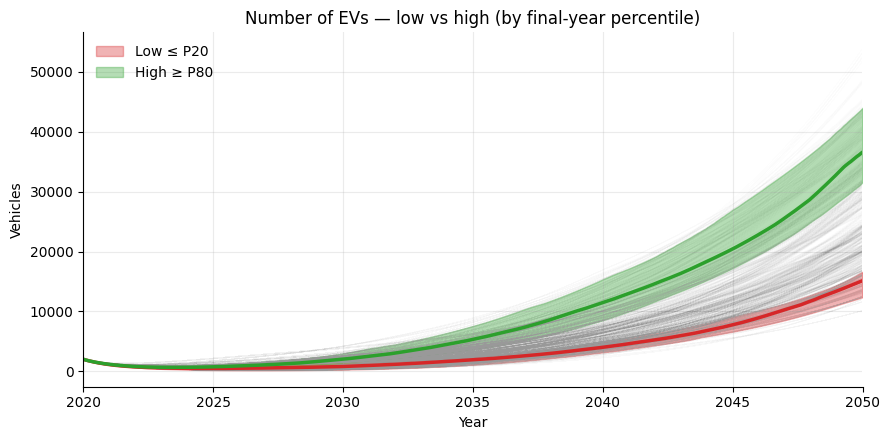

In [88]:
def plot_ev_low_high_percentiles(outcomes,
                                 outcome_name="Number of EVs",
                                 low_q=20, high_q=80,
                                 upsample_factor=8,
                                 show_bands=True,
                                 band_quantiles=(10, 90),
                                 all_runs_alpha=0.01,   # faint grey lines
                                 all_runs_lw=0.5,
                                 low_colour="#d62728",   # red-ish
                                 high_colour="#2ca02c",  # green-ish
                                 median_lw=2.5,
                                 figsize=(9, 4.5)):
    """
    Plot EV adoption with low/high groups (based on final-year EV count) in different colours.
    This version keeps faint grey background lines for all runs,
    while emphasising the red (low) and green (high) percentile bands.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    if outcome_name not in outcomes:
        raise KeyError(f"Outcome '{outcome_name}' not found in outcomes dict")

    arr = outcomes[outcome_name]
    if arr.ndim != 2:
        raise ValueError(f"'{outcome_name}' must be 2D (n_cases, T); got {arr.shape}")

    n_cases, T = arr.shape
    time = outcomes.get("TIME", np.linspace(2020, 2050, T))[0]

    # Define low/high groups by final time step
    final_vals = arr[:, -1].astype(float)
    low_cut  = np.percentile(final_vals, low_q)
    high_cut = np.percentile(final_vals, high_q)
    low_mask  = final_vals <= low_cut
    high_mask = final_vals >= high_cut

    # Interpolation grid
    fine_T = int(T * upsample_factor)
    fine_time = np.linspace(time[0], time[-1], fine_T)

    def _interp_runs(A):
        Y = np.empty((A.shape[0], fine_T))
        for i in range(A.shape[0]):
            Y[i] = np.interp(fine_time, time, A[i].astype(float))
        return Y

    A_all  = _interp_runs(arr)
    A_low  = _interp_runs(arr[low_mask, :])
    A_high = _interp_runs(arr[high_mask, :])

    def _band(Y, qlo, qhi):
        return np.nanpercentile(Y, qlo, axis=0), np.nanpercentile(Y, qhi, axis=0)

    fig, ax = plt.subplots(figsize=figsize)

    # Faint grey background lines
    for i in range(A_all.shape[0]):
        ax.plot(fine_time, A_all[i], color="#999999", alpha=all_runs_alpha, linewidth=all_runs_lw)

    # LOW group band + median
    if show_bands and A_low.shape[0] > 0:
        lo_band, hi_band = _band(A_low, band_quantiles[0], band_quantiles[1])
        ax.fill_between(fine_time, lo_band, hi_band, alpha=0.35, color=low_colour, label=f"Low ≤ P{low_q}")
        ax.plot(fine_time, np.nanmedian(A_low, axis=0), color=low_colour, linewidth=median_lw)

    # HIGH group band + median
    if show_bands and A_high.shape[0] > 0:
        lo_band_h, hi_band_h = _band(A_high, band_quantiles[0], band_quantiles[1])
        ax.fill_between(fine_time, lo_band_h, hi_band_h, alpha=0.35, color=high_colour, label=f"High ≥ P{high_q}")
        ax.plot(fine_time, np.nanmedian(A_high, axis=0), color=high_colour, linewidth=median_lw)

    # Styling
    ax.set_title(f"{outcome_name} — low vs high (by final-year percentile)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Vehicles")
    ax.set_xlim(time[0], time[-1])
    ax.set_xticks(np.arange(2020, 2051, 5))
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left", frameon=False)
    sns.despine()
    plt.tight_layout()
    plt.show()

# --- call for EV adoption, using your same outcome dict ---
plot_ev_low_high_percentiles(outcomes,
                             outcome_name="Number of EVs",
                             low_q=20, high_q=80,
                             upsample_factor=8,
                             show_bands=True)